In [1]:
import re
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import load_iris
from sklearn.tree import _tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier

In [2]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
#     print("def tree({}):".format(", ".join(feature_names)))
    
    all_path = []
    def recurse(node, depth, alist):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
#             print("{}if {} <= {}:".format(indent, name, threshold))
            path_info = "{}<{}".format(tree_.feature[node], round(threshold, 2))
            recurse(tree_.children_left[node], depth + 1, alist+[path_info])
            path_info = "{}>{}".format(tree_.feature[node], round(threshold, 2))
#             print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1, alist+[path_info])
        else:
            if isinstance(tree, DecisionTreeClassifier):
                label = np.argmax(tree_.value[node][0])
                alist.append("{}".format(label))
                all_path.append(alist)
            else:
                val = tree_.value[node][0][0]
                alist.append("{}".format(val))
                all_path.append(alist)
                

    recurse(0, 1, [])
    return all_path

In [3]:

def tree2code(input_node_list):
    tree_result = []
    def dfs(node_id, paths):
        node = input_node_list[node_id]
        if "leaf_value" in node:
            paths.append(str(node["leaf_value"]))
            tree_result.append(paths)
        else:
            left_path = "{0}{1}{2}".format(node["feature_id"][1:], "<", node["feature_value"])
            dfs(int(node["yes_value"]), paths+[left_path])
            
            right_path = "{0}{1}{2}".format(node["feature_id"][1:], ">", node["feature_value"])
            dfs(int(node["no_value"]), paths+[right_path])
    dfs(0, [])
    return tree_result

In [4]:
class GaeaModelSave(object):
    def __init__(self, word2id, tfidfvalue):
        self.word2id = word2id
        self.id2word = {v:k for k, v in word2id.items()}
        self.word_list = [self.id2word[i] for i in range(len(word2id))]
        self.tfidf = [str(round(x, 2)) for x in tfidfvalue]
    
    # 保存模型
    def save_model(self, model, path, filename, **kw):
        model_name = "xxxx"
        full_path = path + filename
        feature_names = kw["feature_names"]
        with open(full_path, "w") as f:
            f.write("model_name--{}\n".format(model_name))
            f.write("class_num--{}\n".format(len(model.classes_)))
            class_num = len(model.classes_)
            if isinstance(model, LogisticRegression):
                f.write("model_type--logistic_regression\n")
                if len(model.classes_) == 2:
                    f.write("logistic_regression_coef--{}\n".format(",".join([str(x) for x in model.coef_[0]])))
                    f.write("logistic_regression_intercept--{}&&{}\n".format(0, model.intercept_[0]))
                else:
                    for i in range(len(model.classes_)):
                        f.write("logistic_regression_coef--{}\n".format(",".join([str(x) for x in model.coef_[i]])))
                        f.write("logistic_regression_intercept--{}\n".format(model.intercept_[i]))
            if isinstance(model, RandomForestClassifier):
                f.write("model_type--random_forest\n")
                f.write("tree_num--{}\n".format(model.n_estimators))
                for i, tree in enumerate(model.estimators_):
                    path_list = tree_to_code(tree, feature_names)
                    for path in path_list:
                        f.write("forest_path--{}%{}\n".format(i, "&&".join(path)))
            elif isinstance(model, DecisionTreeClassifier):
                f.write("model_type--decision_tree\n")
                path_list = tree_to_code(model, feature_names)
                for path in path_list:
                    f.write("tree_path--{}\n".format("&&".join(path)))
            elif isinstance(model, GradientBoostingClassifier):
                f.write("model_type--gradient_boost_decision_tree\n")
                f.write("tree_num--{}\n".format(model.n_estimators))
                for i, trees in enumerate(model.estimators_):
                    for j, tree in enumerate(trees):
                        path_list = tree_to_code(tree, feature_names)
                        for path in path_list:
                            f.write("gbdt_path--{}%{}%{}\n".format(i, j, "&&".join(path)))
            elif isinstance(model, xgb.sklearn.XGBClassifier):
                f.write("model_type--xgboost\n")
                f.write("tree_num--{}\n".format(model.n_estimators))
                
                booster = model.get_booster()
                tree_list = booster.get_dump()
                
                dev_value = 1
                if class_num > 2:
                    dev_value = class_num
                for i, tree in enumerate(tree_list):
                    tree_id = i//dev_value
                    tree_class_id = i%dev_value

                    node_list = []

                    reg = re.compile(r"(?P<tree_id>[\d]*):\[(?P<feature_id>[f\d]*)(?P<operation>[\<\>]*)(?P<feature_value>[-\d\.]*)\] yes=(?P<yes_value>[\d]*),no=(?P<no_value>[\d]*),missing=(?P<missing_value>[\d]*)")
                    reg2= re.compile(r"(?P<tree_id>\d*):leaf=(?P<leaf_value>[-\d\.]*)")

                    for x in tree.split("\n"):
                        x = x.strip()
                        if not x:
                            continue

                        regMatch = reg.match(x)
                        if regMatch:
                            linebits = regMatch.groupdict()
                            node_list.append(linebits)
                        else:
                            regMatch = reg2.match(x)
                            if regMatch:
                                linebits = regMatch.groupdict()
                                node_list.append(linebits)


                    path_list = tree2code(node_list)
                    for path in path_list:
                        f.write("xgb_path--{}%{}%{}\n".format(tree_id, tree_class_id, "&&".join(path)))
            elif isinstance(model, MLPClassifier):
                f.write("model_type--neural_network\n")
                f.write("layer_num--{}\n".format(model.n_layers_))
                f.write("laye_0--{}\n".format(model.coefs_[0].shape[0]))
                
                ind = 1
                for coef in model.coefs_:
                    f.write("laye_{}--{}\n".format(ind, coef.shape[1]))
                    ind += 1
                
                for i, coef in enumerate(model.coefs_):
                    for j, coef_row in enumerate(coef):
                        coef_v = ",".join([str(round(c, 2)) for c in coef_row])
                        f.write("coef_{}_{}--{}\n".format(i, j, coef_v))
                    
                for i, intercepts in enumerate(model.intercepts_):
                    inter_v =  ",".join([str(round(c, 2)) for c in intercepts])
                    f.write("intercept--{}\n".format(inter_v))
                    
            
            f.write("feature_name--{}\n".format(",".join(feature_names)))
            f.write("feature_entity--{}\n".format(",".join(self.word_list)))
            f.write("feature_idf--{}\n".format(",".join( self.tfidf)))

In [5]:
iris = load_iris()
iris_data = iris.data
iris_label = iris.target

In [6]:
lr_iris = LogisticRegression(solver="lbfgs", multi_class="auto", max_iter=200)
lr_iris.fit(iris_data, iris_label)

dt_iris = DecisionTreeClassifier()
dt_iris.fit(iris_data, iris_label)

rf_iris = RandomForestClassifier(n_estimators=10)
rf_iris.fit(iris_data, iris_label)

gbdt_iris = GradientBoostingClassifier(n_estimators=10)
gbdt_iris.fit(iris_data, iris_label)

xgb_iris = xgb.XGBClassifier()
xgb_iris.fit(iris_data, iris_label)

mlp_iris = MLPClassifier()
mlp_iris.fit(iris_data, iris_label)

d:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [8]:
mlp_iris.predict(iris_data)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [79]:
gms = GaeaModelSave({}, {})
gms.save_model(lr_iris,"C:\\Users\\Herman Yang\\source\\repos\\gaea\\UnittestGaeaTest\\", "logistic_regression_iris.gaea", feature_names=iris.feature_names)
gms.save_model(dt_iris,"C:\\Users\\Herman Yang\\source\\repos\\gaea\\UnittestGaeaTest\\", "decision_tree_iris.gaea", feature_names=iris.feature_names)
gms.save_model(gbdt_iris,"C:\\Users\\Herman Yang\\source\\repos\\gaea\\UnittestGaeaTest\\", "gradient_boost_decision_tree_iris.gaea", feature_names=iris.feature_names)
gms.save_model(rf_iris,"C:\\Users\\Herman Yang\\source\\repos\\gaea\\UnittestGaeaTest\\", "random_forest_iris.gaea", feature_names=iris.feature_names)
gms.save_model(xgb_iris,"C:\\Users\\Herman Yang\\source\\repos\\gaea\\UnittestGaeaTest\\", "xgboost_iris.gaea", feature_names=iris.feature_names)
gms.save_model(mlp_iris,"C:\\Users\\Herman Yang\\source\\repos\\gaea\\UnittestGaeaTest\\", "mlp_iris.gaea", feature_names=iris.feature_names)

In [32]:
data = [
    "Sanjay Dutt's acting career has consisted of his work in Bollywood films. ",
    "He made his acting debut in 1981,",
    "opposite Tina Ambani, in his father Sunil Dutt's romantic action film Rocky (1981).",
    "Rocky was ranked as the tenth highest-grossing Bollywood film of 1981.",
    "After appearing in a series of box-office flops,",
    "Sanjay Dutt starred in Mahesh Bhatt's crime thriller film Naam (1986).",
    "He received critical acclaim for his performance,"
    "and it became a turning point in his career.",
    "In 1991, Dutt appeared in Lawrence D'Souza's Indian romantic drama film Saajan (1991),",
    "starring alongside Madhuri Dixit and Salman Khan.",
    "For his performance, he was nominated for the Filmfare Award for Best Actor.",
    "He was nominated again for the same award for his performance in Khalnayak (1993).",
    "Dutt won the Filmfare Award for Best Actor for portraying a young man who later becomes a gangster in Vaastav: The Reality (1999).",
    "He also received critical acclaim for his performance.",
    "Dutt next appeared in Vidhu Vinod Chopra's crime thriller film Mission Kashmir (2000),",
    "for which performance he was again nominated for the Filmfare Award for Best Acto"]

In [33]:
data_encode = []
word2id = {}
for sd in data:
    sds = re.findall("(?u)\\b\\w\\w+\\b", sd)
    sdss = []
    for s in sds:
        if s.lower() not in word2id:
            word2id[s.lower()] = len(word2id)
        sdss.append(str(word2id[s.lower()]))
    data_encode.append(",".join(sdss))

tfidf_vector = TfidfVectorizer(ngram_range=(1,3))
text_data = tfidf_vector.fit_transform(data_encode)
text_label = [0]*7+[1]*8
idf_value = tfidf_vector.idf_

In [31]:
lr_text = LogisticRegression(solver="lbfgs", multi_class="auto", max_iter=200)
lr_text.fit(text_data, text_label)

dt_text = DecisionTreeClassifier()
dt_text.fit(text_data, text_label)

rf_text = RandomForestClassifier(n_estimators=10)
rf_text.fit(text_data, text_label)

gbdt_text = GradientBoostingClassifier(n_estimators=10)
gbdt_text.fit(text_data, text_label)

xgb_text = xgb.XGBClassifier(n_estimators=10)
xgb_text.fit(text_data, text_label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [36]:
gms = GaeaModelSave(word2id, idf_value)
gms.save_model(lr_text,"C:\\Users\\Herman Yang\\source\\repos\\gaea\\UnittestGaeaTest\\", "logistic_regression_text.gaea", feature_names=tfidf_vector.get_feature_names())
gms.save_model(dt_text,"C:\\Users\\Herman Yang\\source\\repos\\gaea\\UnittestGaeaTest\\", "decision_tree_text.gaea", feature_names=tfidf_vector.get_feature_names())
gms.save_model(gbdt_text,"C:\\Users\\Herman Yang\\source\\repos\\gaea\\UnittestGaeaTest\\", "gradient_boost_decision_tree_text.gaea", feature_names=tfidf_vector.get_feature_names())
gms.save_model(rf_text,"C:\\Users\\Herman Yang\\source\\repos\\gaea\\UnittestGaeaTest\\", "random_forest_text.gaea", feature_names=tfidf_vector.get_feature_names())
gms.save_model(xgb_text,"C:\\Users\\Herman Yang\\source\\repos\\gaea\\UnittestGaeaTest\\", "xgboost_text.gaea", feature_names=tfidf_vector.get_feature_names())

In [35]:
tfidf_vector.get_feature_names

<bound method CountVectorizer.get_feature_names of TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)>

0.9

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [11]:
xgb_model = xgb.XGBClassifier()

In [18]:
xgb_model.fit(iris_data, iris_label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [107]:
xgb_model.classes_

array([0, 1, 2])

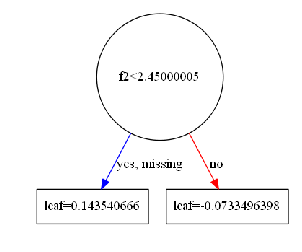

In [68]:
plot_tree(booster)
plt.show()

In [24]:
booster = xgb_model.get_booster()
tree = booster.get_dump(fmap="")[0]

In [66]:
booster.get_dump()

['0:[f2<2.45000005] yes=1,no=2,missing=1\n\t1:leaf=0.143540666\n\t2:leaf=-0.0733496398\n',
 '0:[f2<2.45000005] yes=1,no=2,missing=1\n\t1:leaf=-0.0717703402\n\t2:[f3<1.75] yes=3,no=4,missing=3\n\t\t3:[f2<4.94999981] yes=5,no=6,missing=5\n\t\t\t5:leaf=0.138805971\n\t\t\t6:leaf=-3.25116267e-09\n\t\t4:[f2<4.85000038] yes=7,no=8,missing=7\n\t\t\t7:leaf=-2.55448485e-09\n\t\t\t8:leaf=-0.0712707266\n',
 '0:[f3<1.6500001] yes=1,no=2,missing=1\n\t1:[f2<4.94999981] yes=3,no=4,missing=3\n\t\t3:leaf=-0.0732997581\n\t\t4:leaf=0.0724137947\n\t2:leaf=0.13432835\n',
 '0:[f2<2.45000005] yes=1,no=2,missing=1\n\t1:leaf=0.125266254\n\t2:leaf=-0.0706711337\n',
 '0:[f2<2.45000005] yes=1,no=2,missing=1\n\t1:leaf=-0.0690967366\n\t2:[f3<1.75] yes=3,no=4,missing=3\n\t\t3:[f2<4.94999981] yes=5,no=6,missing=5\n\t\t\t5:leaf=0.121304467\n\t\t\t6:leaf=0.000282830821\n\t\t4:[f2<4.85000038] yes=7,no=8,missing=7\n\t\t\t7:leaf=0.00102581468\n\t\t\t8:leaf=-0.0687237903\n',
 '0:[f3<1.6500001] yes=1,no=2,missing=1\n\t1:[f2<

In [69]:
d = booster.get_dump()[0]

In [103]:
booster.dump_model("booster.txt")

In [102]:
import re
node_list = []

reg = re.compile(r"(?P<tree_id>[\d]*):\[(?P<feature_id>[f\d]*)(?P<operation>[\<\>]*)(?P<feature_value>[-\d\.]*)\] yes=(?P<yes_value>[\d]*),no=(?P<no_value>[\d]*),missing=(?P<missing_value>[\d]*)")
reg2= re.compile(r"(?P<tree_id>\d*):leaf=(?P<leaf_value>[-\d\.]*)")
for i, x in enumerate(d.split("\n")):
    x = x.strip()
    if not x:
        continue
        
    regMatch = reg.match(x)
    if regMatch:
        linebits = regMatch.groupdict()
        node_list.append(linebits)
    else:
        regMatch = reg2.match(x)
        if regMatch:
            linebits = regMatch.groupdict()
            node_list.append(linebits)

tree2code(node_list)
        

[['2<2.45000005', '0.143540666'], ['2>2.45000005', '-0.0733496398']]

In [84]:
line2 = "1:leaf=0.143540666"
reg2= re.compile(r"(?P<tree_id>\d*):leaf=(?P<leaf_value>[\d\.]*)")

In [83]:
regMatch = reg.match(line)
linebits = regMatch.groupdict()
print(linebits)

{'tree_id': '0', 'feature_id': 'f2', 'operation': '<', 'feature_value': '2.45000005', 'yes_value': '1', 'no_value': '2', 'missing_value': '1'}


In [85]:
regMatch2 = reg2.match(line2)
linebits2 = regMatch2.groupdict()
print(linebits2)

{'tree_id': '1', 'leaf_value': '0.143540666'}
